Importing the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature # This pacakge is used for LBP feature extraction
from sklearn import svm # This pacakge is used for svm classification
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline
import cv2
import seaborn as sns # This pacakge is used for better visualization of data (e.g confusion matrix)

Loading the **dataset**

In [2]:
import os
from os.path import isfile, join
import re

mypath = 'dataset_42028assg1_13918471'
categories = ['!', ')', '[', '+', '=', 'cos', 'div', 'sum', 'tan', 'times']
dataset = []
img_index_arr = []
# files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

def load_data():
    for category in categories:
        path = os.path.join(mypath, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img),0)
                new_array = cv2.resize(img_array, (40,40))
                dataset.append(new_array)
                img_index_arr.append(class_num)
            except Exception as e:
                print(e)


In [3]:
load_data()

Displaying examples from the dataset

!
)
+
sum


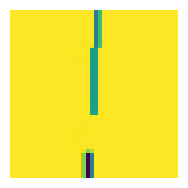

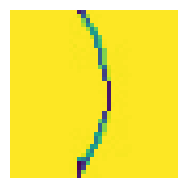

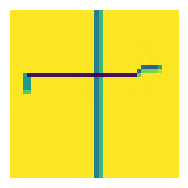

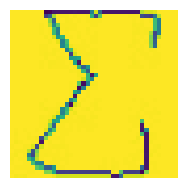

In [4]:
datasetArr = np.array(dataset)

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.axis('off')
ax1.imshow(dataset[0])
print(categories[img_index_arr[0]])

fig = plt.figure()
ax1 = fig.add_subplot(2,2,2)
ax1.axis('off')
ax1.imshow(dataset[500])
print(categories[img_index_arr[500]])

fig = plt.figure()
ax1 = fig.add_subplot(2,2,3)
ax1.axis('off')
ax1.imshow(dataset[1500])
print(categories[img_index_arr[1500]])

fig = plt.figure()
ax1 = fig.add_subplot(2,2,4)
ax1.axis('off')
ax1.imshow(dataset[3500])
print(categories[img_index_arr[3500]])


Splitting the dataset into training and testing sets

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(datasetArr, img_index_arr)

Creating the LBP function

In [6]:
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius

	def LBPfeatures(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
    # Form the histogram
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))

		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)

		# return the histogram of Local Binary Patterns
		return hist

In [7]:
# Create an object of LocalBinaryPatterns class and initial the parameters.
desc = LocalBinaryPatterns(24, 8)
data_train = []
labels_train = []

# loop over the training images
for img_index in range(len(X_train)):
	# load the image, convert it to grayscale, and extract LBP features
	image = (X_train[img_index])
	hist = desc.LBPfeatures(image)

	# extract the label from the image path, then update the
	# label and data lists
	labels_train.append(Y_train[img_index])
	data_train.append(hist)

In [8]:
# train a SVM clasifier on the training data
# Initialize the SVM model
model = svm.SVC(kernel='rbf',C=100.0, random_state=42) # rbf Kernel
# Start training the SVM classifier
model.fit(data_train, labels_train)

print(np.shape(data_train))
print(np.shape(labels_train))

(3750, 26)
(3750,)


In [9]:
# Check the training accuray
print("Train set Accuracy: {:.2f}".format(model.score(data_train,labels_train)))

# Expected training set Accuracy 0.60

Train set Accuracy: 0.85


In [10]:
predictions=[]
predict_label=[]
# Exract LBP features for each test sample and classify it with the trained SVM classifier
for im_index in range(len(X_test)):
  imag = X_test[im_index]
  # Extract LBP feature
  histo = desc.LBPfeatures(imag)
  # Perform classification
  prediction = model.predict(histo.reshape(1, -1))
  # Store the classfication result
  predictions.append(prediction)
  predict_label.append(Y_test[im_index])

In [11]:
accuracy = metrics.accuracy_score(Y_test, predictions)
print("Accuracy on test dataset:",accuracy)

Accuracy on test dataset: 0.836


[[123   4   2   0   0   0   0   0   0   0]
 [  1 121   8   0   0   0   0   0   0   0]
 [  7   3 121   0   0   0   2   0   0   0]
 [  0   0   1 103   6   0   6   1   2   0]
 [  0   1   4   1 104   0   3   4   2   6]
 [  0   1   1   0   0  98   0   3  14   6]
 [  5   7   1  16   2   0  93   2   0   2]
 [  0   1   2   0   6   3   2  80   2  10]
 [  0   0   0   8   4   8   0   6 105   9]
 [  0   0   0   4   2   5   0   1   8  97]]


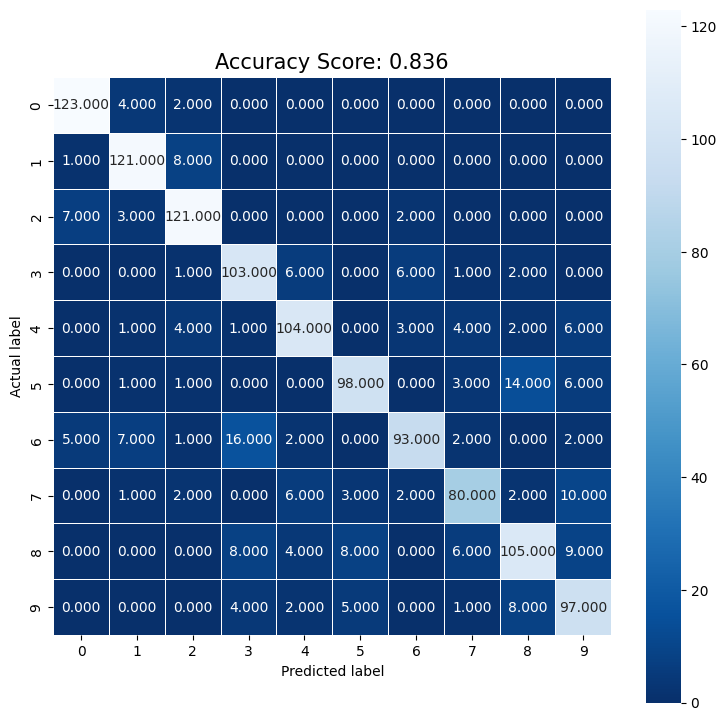

In [12]:
# plot the confusion matrix
cm  = metrics.confusion_matrix(Y_test, predictions)
print(cm)

# Plot confusion matrix using seaborn library
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [13]:
# Display the some classification result on test samples
images = []

# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(Y_test)), size=(16,)):
  # classify the clothing
  histog = desc.LBPfeatures(X_test[i])
  prediction = model.predict(histog.reshape(1, -1))
  label = categories[prediction[0]]
  orig_label=categories[Y_test[i]]
  image = X_test[i]
  color = (0, 255, 0)
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.50, color, 1)
  images.append(image)

tan


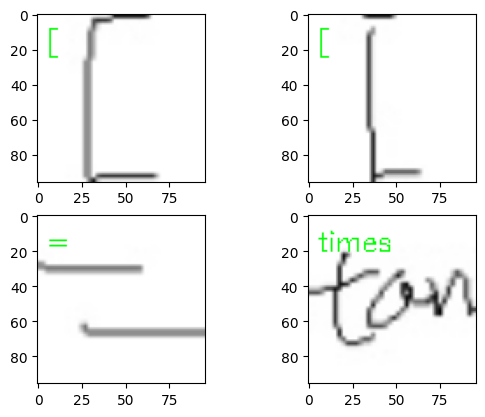

In [14]:
## Display the classification results
#Plot the image and the predicted labels
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(images[1])
print(orig_label[:])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(images[2])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(images[3])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(images[4])

In [15]:
model = svm.SVC(kernel='rbf',C=100.0, random_state=42) # rbf Kernel
model.fit(data_train, labels_train)

SVC(C=100.0, random_state=42)

In [16]:
print("Train set Accuracy: {:.2f}".format(model.score(data_train,labels_train)))


Train set Accuracy: 0.85
